# StableDiffusion image interpolation / videos

## Instructions

- Set up stable diffusion using the instructions [here](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- also run ```pip install imageio_ffmpeg opencv-python imageio```
- Run all the following cells - the first time may take >10 minutes for downloading the checkpoints (sorry that the code is such a huge mess!)

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
import torch
from tqdm import tqdm, trange
from torch import autocast
from PIL import Image
import imageio
import numpy as np
from matplotlib import pyplot as plt
import inspect
import cv2
import pickle

device = 'cuda'

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [2]:
# compute embedding for single prompt
def prompt_to_text_emb(prompt):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        return text_encoder(text_input.input_ids.to(device))[0], text_input.input_ids.shape[-1]

In [3]:
# run generator starting from embedding
def generate(text_embeddings, max_length, height, width, num_inference_steps, guidance_scale, seed, batch_size):
    generator = torch.manual_seed(seed)
    
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]   
        
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(device)
    
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    #scheduler = PNDMScheduler()
    
    # set timesteps
    accepts_offset = "offset" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
    extra_set_kwargs = {}
    if accepts_offset:
        extra_set_kwargs["offset"] = 1

    scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
    
    # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
    if isinstance(scheduler, LMSDiscreteScheduler):
        latents = latents * scheduler.sigmas[0]

    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta
    
    
    with autocast("cuda"):
        for i, t in (enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            if isinstance(scheduler, LMSDiscreteScheduler):
                sigma = scheduler.sigmas[i]
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(scheduler, LMSDiscreteScheduler):
                latents = scheduler.step(noise_pred, i, latents, **extra_step_kwargs)["prev_sample"]
            else:
                latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

            
    return latents

In [4]:
def decode_latents(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        return vae.decode(latents)

In [5]:
def interpolate_single_from_prompts(prompts, contin_ind):
    i1 = int(contin_ind)
    prompt1 = prompts[i1]
    emb1, max_length1 = prompt_to_text_emb(prompt1)
    if contin_ind == len(prompts)-1:
        return emb1, max_length1
    
    i2 = i1+1
    lerp = contin_ind-i1
    prompt2 = prompts[i2]
    emb2, max_length2 = prompt_to_text_emb(prompt2)
    assert max_length1 == max_length2
    
    return emb1*(1-lerp) + emb2*lerp, max_length1

In [6]:
def generate_e2e(i_contin, prompts, height, width, num_inference_steps, guidance_scale, seed):
    emb, max_length = interpolate_single_from_prompts(prompts, i_contin)
    latent = generate(
            text_embeddings=emb,
            max_length=max_length,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps, 
            guidance_scale=guidance_scale, 
            seed=seed,
            batch_size=1
        )
    image = decode_latents(latent)
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [7]:
def n_imshow(*imgs, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(6*(len(imgs)-0.15), 6))
    for img, ax in zip(imgs, axes):
        ax.imshow(img, **kwargs)
    plt.show()

## Configuration & generate the main images
- change settings as you like
- make sure the image for each of the prompts looks good
- atm you can only use one seed for all prompts

100%|██████████| 6/6 [00:25<00:00,  4.33s/it]


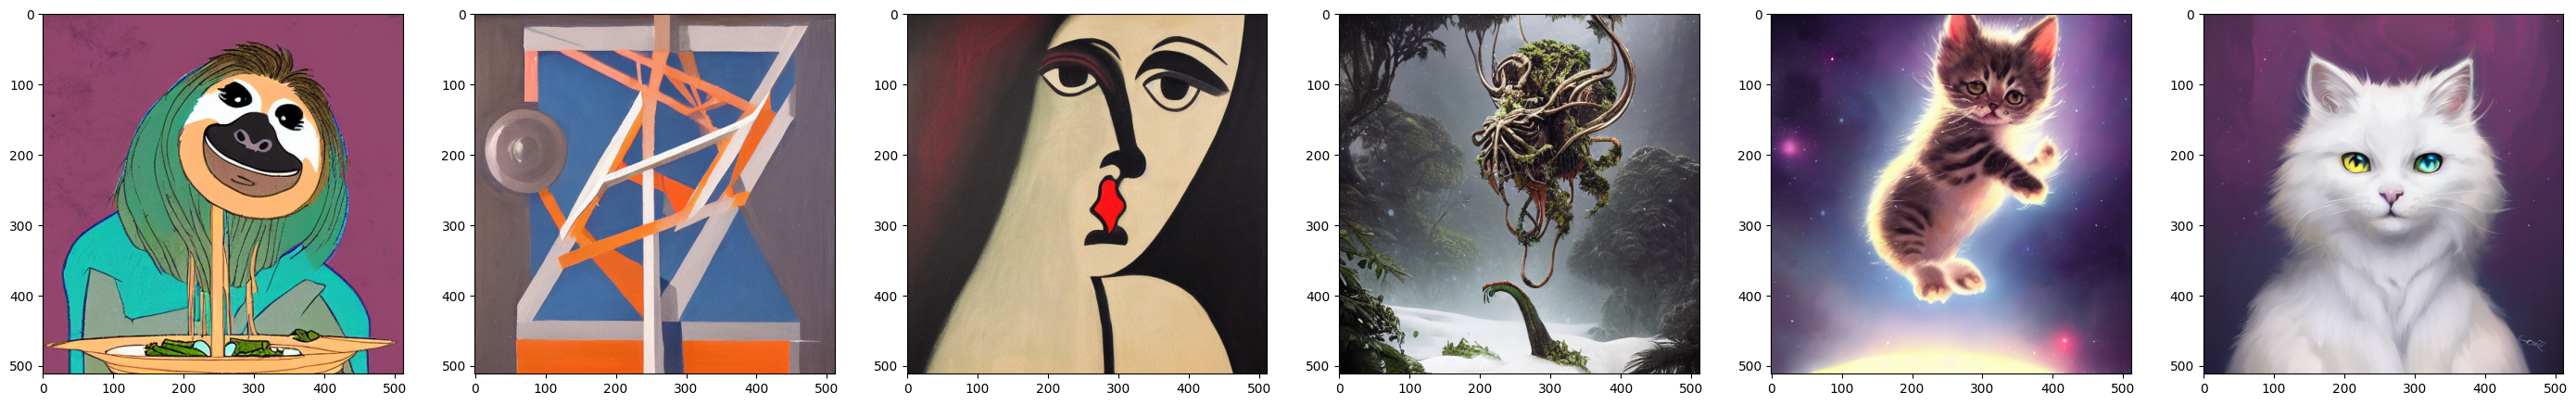

In [8]:
# generation settings

settings = dict(
    height=512,
    width=512,
    num_inference_steps=50,
    guidance_scale=7.5,
    seed=1,
)

prompts = [
    'A sloth with teal hair eating onions in a temple, Comic-style art',
    'Good morning, as a Constructivist painting',
    '"Jealousy", masterful painting, Bauhaus style',
    'creature in a lush trunda vegetation, snow :: by Michal Karcz, Daniel Merriam, Victo Ngai and Guillermo del toro :: ornate, dynamic, particulate, intricate, elegant, highly detailed, centered, artstation, smooth, sharp focus, octane render, 3d',
    'a closeup of a single cartoonish kitten floating in space, bright stars, anime, a fantasy digital painting by Greg Rutkowski and James Gurney, trending on Artstation, highly detailed',
    'a portrait of a beautiful white fluffy cat with yellow eyes, art by lois van baarle and loish and ross tran and rossdraws and sam yang and samdoesarts and artgerm, digital art, highly detailed, intricate, sharp focus, Trending on Artstation HQ, deviantart, unreal engine 5, 4K UHD image',
]

w, h = settings['width'], settings['height']
result_contin_i = []
result_images = []

# generate 1 image for each prompt
for i in trange(len(prompts)):
    result_contin_i.append(i)
    result_images.append(generate_e2e(i, prompts, **settings))
n_imshow(*[np.array(img) for img in result_images])

# Pairwise interpolation

100%|██████████| 6/6 [02:31<00:00, 25.22s/it]


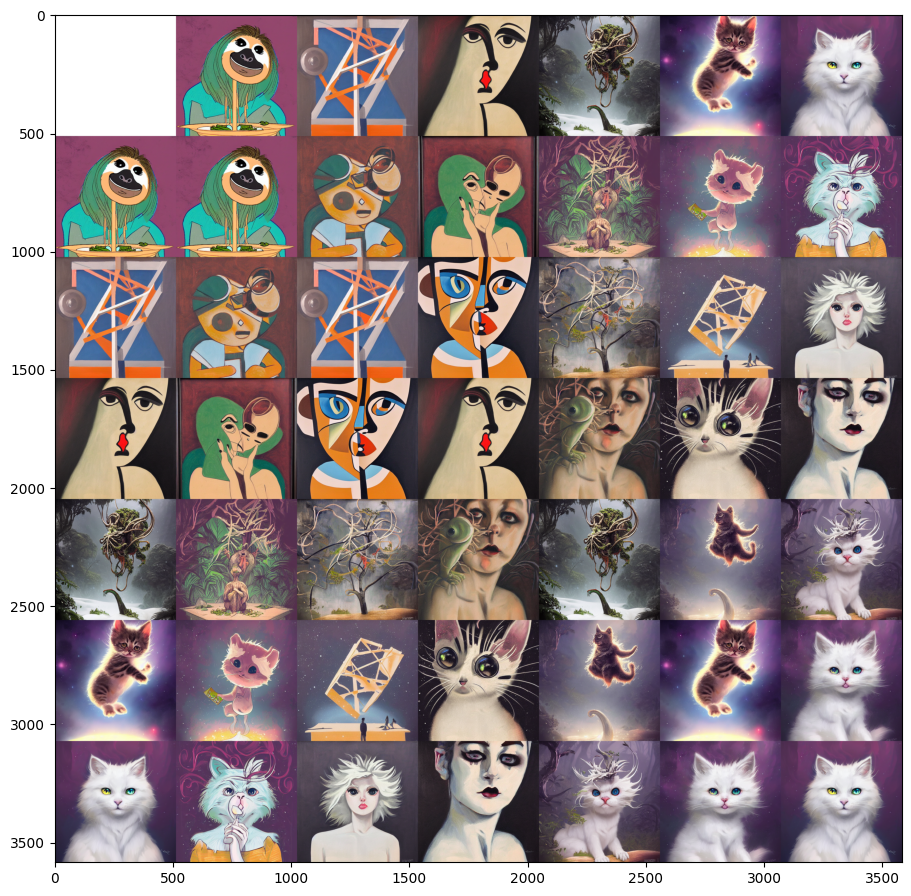

In [9]:
pairwise_result = np.ones((h*(len(prompts)+1), w*(len(prompts)+1), 3), dtype=np.uint8)
pairwise_result *= 255

for i in range(1, len(prompts)+1):
    pairwise_result[0:h, i*w:i*w+w] = np.array(result_images[i-1])
    pairwise_result[i*h:i*h+h, 0:w] = np.array(result_images[i-1])

for i, p1 in enumerate(tqdm(prompts)):
    for j, p2 in enumerate(prompts):
        result_img = generate_e2e(0.5, [p1, p2], **settings)
        pairwise_result[(i+1)*h:(i+2)*h, (j+1)*w:(j+2)*w] = np.array(result_img)
        
plt.figure(figsize=(11, 11))
plt.imshow(pairwise_result)
plt.show()
imageio.imwrite('stablediff_pairwise.png', pairwise_result)

## Multiple-steps

100%|██████████| 3/3 [01:28<00:00, 29.45s/it]


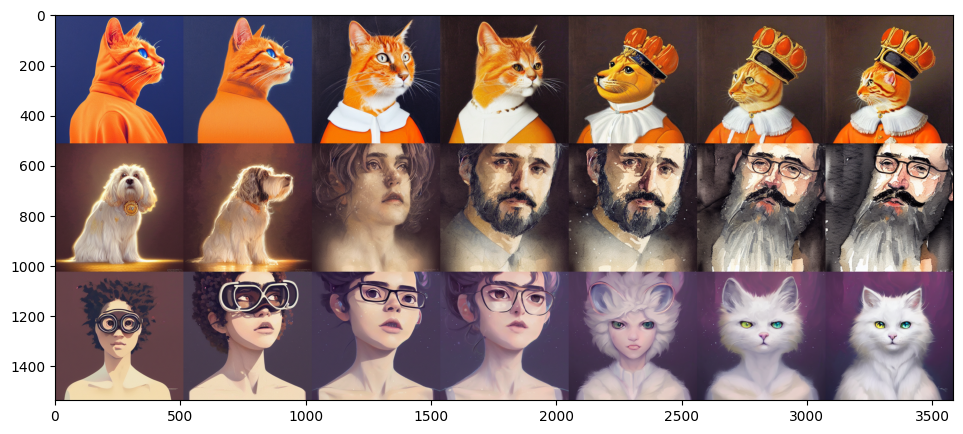

In [10]:
prompt_pairs = [
    [
        'A side bust portrait of orange cat standing up like a human in a blue down uniqlo jacket with the hood up, looking up, black background, studio lighting, vibrant, high contrast, dramatic lighting, light from above, trending art, artstation, professional, hyper realistic pencil crayon, solvent blended',
        'Painting of the orange cat Otto von Garfield, Count of Bismarck-Schönhausen, Duke of Lauenburg, Minister-President of Prussia. Depicted wearing a Prussian Pickelhaube and eating his favorite meal - lasagna.',
    ],
    [
        'beautiful detailed picture of a havanese, radiant light, art nouveau, intricate, elegant, highly detailed, my rendition, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha',
        'portrait of a middle-aged writer with a beard, watercolor style of greg rutkowski',
    ],
    [
        'Beautiful woman wearing goggles profile picture by Greg Rutkowski, brown skin, afro hair, asymmetrical, studio ghibli, Organic Painting , Matte Painting, geometric shapes, hard edges, street art, trending on the artstation, realistic by Sachin Teng',
        'a portrait of a beautiful white fluffy cat with yellow eyes, art by lois van baarle and loish and ross tran and rossdraws and sam yang and samdoesarts and artgerm, digital art, highly detailed, intricate, sharp focus, Trending on Artstation HQ, deviantart, unreal engine 5, 4K UHD image',
    ]
]

n = 7 # how many interpolation steps
multistep_result = np.zeros((h*len(prompt_pairs), w*n, 3), dtype=np.uint8)

for r, prompt_pair in enumerate(tqdm(prompt_pairs)):
    for i, k in enumerate(np.linspace(0, 1, n)):
        result_img = generate_e2e(k, prompt_pair, **settings)
        multistep_result[r*h:(r+1)*h, i*w:(i+1)*w] = result_img
plt.figure(figsize=(14, 5))
plt.imshow(multistep_result)
plt.show()
imageio.imwrite('stablediff_multistep.png', multistep_result)

# Videos

In [ ]:
def dist(x1, x2):
    x1 = cv2.resize(np.array(x1), (0,0), fx=0.375, fy=0.375, interpolation=cv2.INTER_AREA) 
    x2 = cv2.resize(np.array(x2), (0,0), fx=0.375, fy=0.375, interpolation=cv2.INTER_AREA)
    
    return ((x1-x2)**2).mean()

The next cell repeatedly inserts new frames into the existing sequence of frames stored in `result_images`. Frames are inserted wherever the visual distance beween consecutive frames is large. Let this run for some time (minutes-hours), then interrupt and run the next cells to generate and export the video.

In [ ]:
threshold = 100.5

while threshold > 0:
    stop = False
    while not stop:
        i = 0
        stop = True
        while i < len(result_images)-1:
            diff = dist(result_images[i], result_images[i+1])

            if diff > threshold and result_contin_i[i+1]-result_contin_i[i] > 0.0005:
                stop = False
                new_contin_i = (result_contin_i[i]+result_contin_i[i+1])/2
                new_image = generate_e2e(new_contin_i, prompts, **settings)
                result_images = result_images[:i+1] + [new_image] + result_images[i+1:]
                result_contin_i = result_contin_i[:i+1] + [new_contin_i] + result_contin_i[i+1:]

                
                # disable the imshow if you want to run it for longer
                print(f'Inserting frame between {i} and {i+1}, previous distance between frames was {diff}, new distances are {(dist(result_images[i], result_images[i+1]), dist(result_images[i+1], result_images[i+2]))}')
                print(f'Left and right images are old, center is the inserted one')
                n_imshow(np.array(result_images[i]), np.array(result_images[i+1]), np.array(result_images[i+2]))
                i += 1
            i += 1

    threshold -= 10
    print('Threshold set to', threshold)

In [ ]:
video_fps = 120 # adjust this based on how long you ran the interpolation for and how it looks

wr = imageio.get_writer('stablediff_video.mp4', fps=video_fps)
    
for c in trange(len(result_contin_i)):
    frame = result_images[c]
    
    last_written_frame = np.array(frame) if c == 0 else next_frame_to_write
    next_frame_to_write = np.array(frame)
    
    n_reps = max(round(np.sqrt(dist(last_written_frame, next_frame_to_write))), 1)
    for i in range(n_reps):
        wr.append_data(next_frame_to_write)
        
    c += 1
    
wr.close()

In [ ]:
from IPython.display import Video
Video("stablediff_video.mp4")